<a href="https://colab.research.google.com/github/euguroglu/Kaggle/blob/master/Kaggle_Titanic_Survival_Classification_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import figure
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data check and preperation

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

In [6]:
df['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

In [7]:
df.set_index('PassengerId',inplace=True)

In [8]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


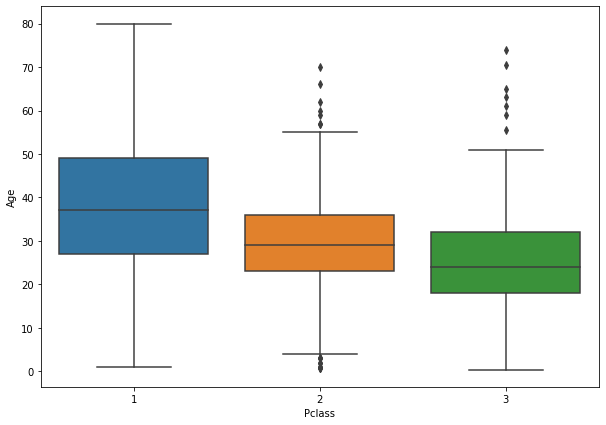

In [11]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age',data=df)

In [12]:
class_1 = df[df['Pclass'] == 1]
class_1['Age'].mean()

38.233440860215055

In [13]:
class_2 = df[df['Pclass'] == 2]
class_2['Age'].mean()

29.87763005780347

In [14]:
class_3 = df[df['Pclass'] == 3]
class_3['Age'].mean()

25.14061971830986

In [15]:
def impute_age(cols):
  Age = cols[0]
  Pclass = cols[1]

  if pd.isnull(Age):

    if Pclass == 1:
      return 38
    elif Pclass == 2:
      return 30
    else:
      return 25
  else:
    return Age

In [16]:
df['Age'] = df[['Age','Pclass']].apply(impute_age,axis=1)

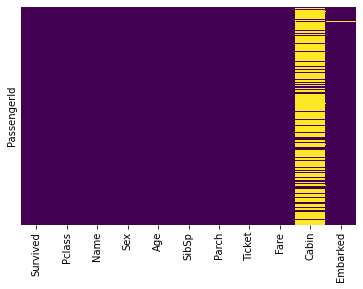

In [18]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [19]:
df.drop('Cabin',axis=1,inplace=True)

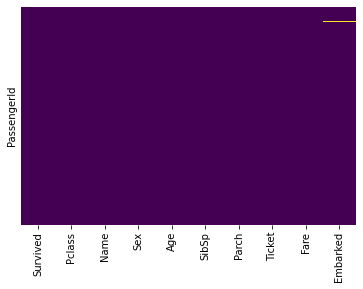

In [20]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [21]:
df.dropna(inplace=True)

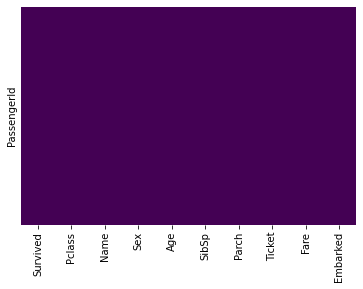

In [22]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [23]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')

Data seperation categorial and continous

In [24]:
cat_cols = ['Sex','Embarked','Pclass']
cont_cols = ['Age','SibSp','Parch','Fare']
y_col = ['Survived']

In [25]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [26]:
Sx = df['Sex'].cat.codes.values
Em = df['Embarked'].cat.codes.values
Pc = df['Pclass'].cat.codes.values

cats = np.stack([Sx,Em,Pc], 1)
cats = torch.LongTensor(cats)

In [27]:
cats

tensor([[1, 2, 2],
        [0, 0, 0],
        [0, 2, 2],
        ...,
        [0, 2, 2],
        [1, 0, 0],
        [1, 1, 2]])

In [28]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.FloatTensor(conts)
conts[:5]

tensor([[22.0000,  1.0000,  0.0000,  7.2500],
        [38.0000,  1.0000,  0.0000, 71.2833],
        [26.0000,  0.0000,  0.0000,  7.9250],
        [35.0000,  1.0000,  0.0000, 53.1000],
        [35.0000,  0.0000,  0.0000,  8.0500]])

In [29]:
y = torch.tensor(df[y_col].values).flatten()

y[:5]

tensor([0, 1, 1, 1, 0])

Data preperation for embedding

In [30]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (3, 2), (3, 2)]

In [31]:
cat_szs 

[2, 3, 3]

Neural Network

In [32]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.4):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [33]:
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2

Model summary

In [34]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(3, 2)
    (2): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

Cost function and optimization

In [35]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss performs better for classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
cat_train = cats
con_train = conts
y_train = y

Training

In [37]:
import time
start_time = time.time()

epochs = 3000
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
  
    # a neat trick to save screen space:
    if i%10 == 1:
        print('Epoch: {} and Loss: {:8.4f}'.format(i,loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch: 1 and Loss:   0.7283
Epoch: 11 and Loss:   0.5469
Epoch: 21 and Loss:   0.5235
Epoch: 31 and Loss:   0.5312
Epoch: 41 and Loss:   0.5242
Epoch: 51 and Loss:   0.5035
Epoch: 61 and Loss:   0.5008
Epoch: 71 and Loss:   0.4951
Epoch: 81 and Loss:   0.4980
Epoch: 91 and Loss:   0.4795
Epoch: 101 and Loss:   0.4897
Epoch: 111 and Loss:   0.4644
Epoch: 121 and Loss:   0.4803
Epoch: 131 and Loss:   0.4655
Epoch: 141 and Loss:   0.4785
Epoch: 151 and Loss:   0.4861
Epoch: 161 and Loss:   0.4678
Epoch: 171 and Loss:   0.4594
Epoch: 181 and Loss:   0.4496
Epoch: 191 and Loss:   0.4641
Epoch: 201 and Loss:   0.4526
Epoch: 211 and Loss:   0.4581
Epoch: 221 and Loss:   0.4434
Epoch: 231 and Loss:   0.4778
Epoch: 241 and Loss:   0.4691
Epoch: 251 and Loss:   0.4561
Epoch: 261 and Loss:   0.4476
Epoch: 271 and Loss:   0.4560
Epoch: 281 and Loss:   0.4566
Epoch: 291 and Loss:   0.4572
Epoch: 301 and Loss:   0.4543
Epoch: 311 and Loss:   0.4564
Epoch: 321 and Loss:   0.4744
Epoch: 331 and Loss: 

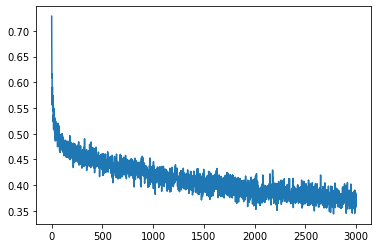

In [38]:
plt.plot(range(epochs),losses)

Prediction

In [43]:
df2 = pd.read_csv('test.csv')

In [44]:
df2

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [45]:
df2.set_index('PassengerId',inplace=True)

In [46]:
df2.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


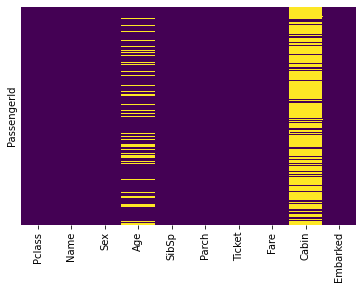

In [47]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
 df2.fillna(df2.mean(),inplace=True)

In [48]:
df2['Age'] = df2[['Age','Pclass']].apply(impute_age,axis=1)

In [49]:
df2.drop('Cabin',axis=1,inplace=True)

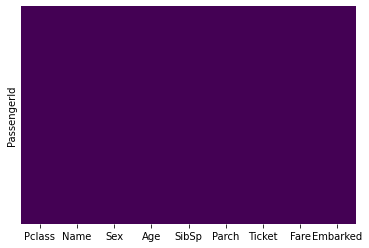

In [50]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
df2['SibSp'].unique()

In [ ]:
len(df2)

418

In [51]:
cat_cols = ['Sex','Embarked','Pclass']
cont_cols = ['Age','SibSp','Parch','Fare']
y_col = ['Survived']

In [52]:
for cat in cat_cols:
    df2[cat] = df2[cat].astype('category')

In [53]:
Sx = df2['Sex'].cat.codes.values
Em = df2['Embarked'].cat.codes.values
Pc = df2['Pclass'].cat.codes.values

cats_t = np.stack([Sx,Em,Pc], 1)
cats_t = torch.LongTensor(cats)

In [54]:
conts_t = np.stack([df2[col].values for col in cont_cols], 1)
conts_t = torch.FloatTensor(conts)

In [55]:
cat_test = cats_t
con_test = conts_t


In [56]:
with torch.no_grad():
    y_val = model(cat_test,con_test)
    
    

In [57]:
Surviverlist = []
for i in range(418):
  Surviverlist.append([df2.index[i],y_val[i].argmax().numpy()])

    
  print('{}.) Predicted:: {:8.2f}'.format(df2.index[i],y_val[i].argmax().numpy()))

892.) Predicted::     0.00
893.) Predicted::     1.00
894.) Predicted::     0.00
895.) Predicted::     1.00
896.) Predicted::     0.00
897.) Predicted::     0.00
898.) Predicted::     0.00
899.) Predicted::     0.00
900.) Predicted::     1.00
901.) Predicted::     1.00
902.) Predicted::     1.00
903.) Predicted::     0.00
904.) Predicted::     0.00
905.) Predicted::     0.00
906.) Predicted::     0.00
907.) Predicted::     0.00
908.) Predicted::     0.00
909.) Predicted::     0.00
910.) Predicted::     0.00
911.) Predicted::     0.00
912.) Predicted::     1.00
913.) Predicted::     0.00
914.) Predicted::     0.00
915.) Predicted::     1.00
916.) Predicted::     0.00
917.) Predicted::     0.00
918.) Predicted::     0.00
919.) Predicted::     1.00
920.) Predicted::     1.00
921.) Predicted::     0.00
922.) Predicted::     0.00
923.) Predicted::     1.00
924.) Predicted::     0.00
925.) Predicted::     0.00
926.) Predicted::     1.00
927.) Predicted::     0.00
928.) Predicted::     0.00
9

In [58]:
Surviverlist

[[892, array(0)],
 [893, array(1)],
 [894, array(0)],
 [895, array(1)],
 [896, array(0)],
 [897, array(0)],
 [898, array(0)],
 [899, array(0)],
 [900, array(1)],
 [901, array(1)],
 [902, array(1)],
 [903, array(0)],
 [904, array(0)],
 [905, array(0)],
 [906, array(0)],
 [907, array(0)],
 [908, array(0)],
 [909, array(0)],
 [910, array(0)],
 [911, array(0)],
 [912, array(1)],
 [913, array(0)],
 [914, array(0)],
 [915, array(1)],
 [916, array(0)],
 [917, array(0)],
 [918, array(0)],
 [919, array(1)],
 [920, array(1)],
 [921, array(0)],
 [922, array(0)],
 [923, array(1)],
 [924, array(0)],
 [925, array(0)],
 [926, array(1)],
 [927, array(0)],
 [928, array(0)],
 [929, array(0)],
 [930, array(0)],
 [931, array(1)],
 [932, array(0)],
 [933, array(0)],
 [934, array(0)],
 [935, array(1)],
 [936, array(1)],
 [937, array(0)],
 [938, array(0)],
 [939, array(1)],
 [940, array(0)],
 [941, array(0)],
 [942, array(0)],
 [943, array(0)],
 [944, array(1)],
 [945, array(1)],
 [946, array(0)],
 [947, arr

In [59]:
df3 = pd.DataFrame(Surviverlist)

In [60]:
df3.to_excel(r'C:\sample_data\submission.xlsx', index = False)